In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from ot import cost_matrix, sinkhorn
from math import pi
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Example 1

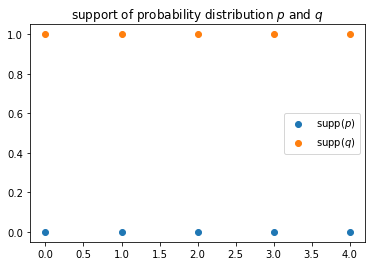

In [2]:
# Two probability distribution
n_points = 5
a = np.array([[i, 0] for i in range(n_points)])
b = np.array([[i, 1] for i in range(n_points)])

plt.figure()
plt.scatter(a[:, 0], a[:, 1], label='supp($p$)')
plt.scatter(b[:, 0], b[:, 1], label='supp($q$)')
plt.title('support of probability distribution $p$ and $q$')
plt.legend()

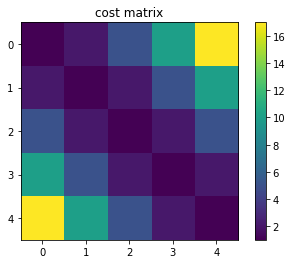

In [3]:
x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)
C1 = cost_matrix(x, y, 2)
plt.figure()
plt.imshow(C1)
plt.title('cost matrix')
plt.colorbar()
plt.show()

In [4]:
A1 = torch.ones(1, n_points) / n_points
B1 = torch.ones(1, n_points) / n_points
eps1 = 1
dist1, P1, actual_niter1 = sinkhorn(A1, B1, C1, eps1)
print(f"Sinkhorn distance of two distribution is {dist1.item():.4f}, actual number of iteration is {actual_niter1}")

Sinkhorn distance of two distribution is 1.4079, actual number of iteration is 100


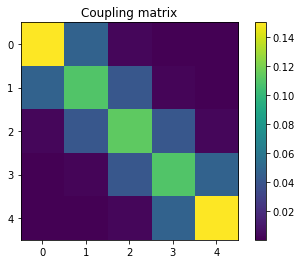

In [5]:
plt.figure()
plt.imshow(P1[0])
plt.title('Coupling matrix')
plt.colorbar()
plt.show()

## Example 2

In [6]:
def signal2(t):
    u = torch.cos(t)
    u[t>0.5*pi] = 0
    u[t<-0.5*pi] = 0
    return u

In [7]:
nt2 = 100
t2 = torch.linspace(-3.5*pi, 3.5*pi, nt2)
u = signal2(t2)

In [8]:
def shift(u, s):
    n = len(u)
    if torch.abs(torch.tensor(s)) >= n:
        raise ValueError('s should be small than length of u')
    if s > 0:
        u = torch.cat((torch.full((s,), 0.), u[:-s]))
    elif s < 0:
        u = torch.cat((u[-s:], torch.full((-s,), 0.)))
    return u

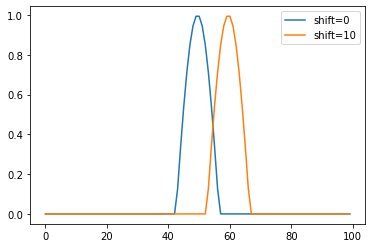

In [9]:
v = shift(u, 10)
plt.figure()
plt.plot(u, label='shift=0')
plt.plot(v, label='shift=10')
plt.legend()
plt.show()

In [10]:
t2 = t2.reshape(-1, 1)
C2 = cost_matrix(t2, t2, p=2)

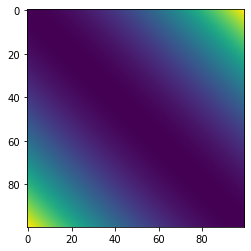

In [11]:
plt.imshow(C2)

In [12]:
s2 = torch.arange(-30, 30, 2)
A2 = torch.zeros(len(s2), len(t2))
B2 = torch.zeros(len(s2), len(t2))
for i, st in enumerate(s2):
    A2[i, :] = u
    B2[i, :] = shift(u, st)

C:\Users\zchen\.conda\envs\dl\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
dist2, P2, actual_niter2 = sinkhorn(A2, B2, C2, 3)
actual_niter2

18

In [22]:
l2_error2 = torch.sum((A2-B2)**2, dim=1)

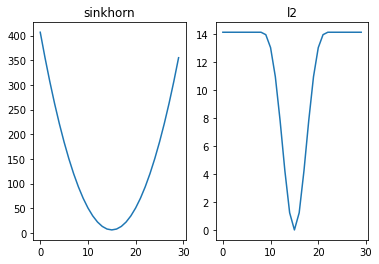

In [32]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(dist2.numpy())
ax1.set_title('sinkhorn')
ax2.plot(l2_error2)
ax2.set_title('l2')
plt.show()

## Example 3

In [50]:
def ricker(t, f0, t0):
    tmp = pi**2 * f0**2 * (t - t0)**2
    return  (1 - 2 * tmp) * torch.exp(-tmp)

In [51]:
t3 = torch.arange(100) * 0.001
u3 = ricker(t3, 50, 50*0.001)
u3.shape

torch.Size([100])

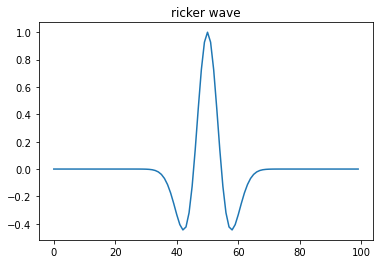

In [52]:
plt.figure()
plt.plot(u3.numpy())
plt.title('ricker wave')
plt.show()

In [53]:
t03 = torch.arange(20, 80) * 0.001
A3 = torch.zeros(len(t03), len(t3))
B3 = torch.zeros(len(t03), len(t3))
for i, t0 in enumerate(t03):
    A3[i, :] = u3
    B3[i, :] = ricker(t3, 50, t0)

In [54]:
l2_error3 = torch.sum((A3-B3)**2, dim=1)

In [35]:
#C3 = cost_matrix(t3.reshape(-1, 1), t3.reshape(-1, 1), p=2)

In [36]:
# A3 = A3 ** 2
# A3 = A3 / torch.sum(A3, dim=1, keepdim=True)
# B3 = B3 ** 2
# B3 = B3 / torch.sum(B3, dim=1, keepdim=True)

In [37]:
# dist3, P3, actual_niter3 = sinkhorn(A3, B3, C3, eps=0.1)
# actual_niter3

100

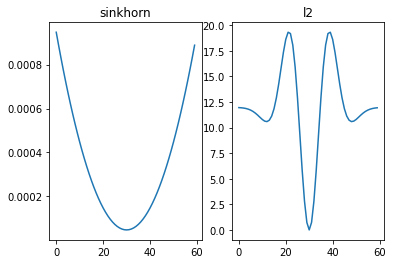

In [38]:
# _, (ax1, ax2) = plt.subplots(1, 2)
# ax1.plot(dist3.numpy())
# ax1.set_title('sinkhorn')
# ax2.plot(l2_error3)
# ax2.set_title('l2')
# plt.show()
# del dist3
# del P3 
# del actual_niter3

In [55]:
B3.requires_grad_()
dist3, P3, actual_niter3 = sinkhorn_wave(A3, B3, t3)

In [56]:
actual_niter3

100

In [57]:
e3 = torch.mean(dist3)
e3.backward()

In [61]:
g3 = B3.grad.data
torch.any(torch.isnan(g3))

tensor(False)

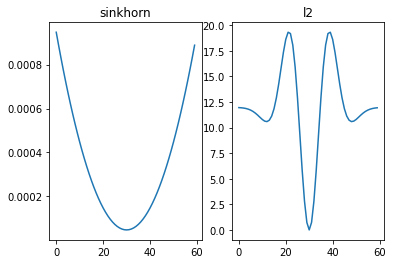

In [48]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(dist3.numpy())
ax1.set_title('sinkhorn')
ax2.plot(l2_error3)
ax2.set_title('l2')
plt.show()